# Plain-Text CNN

## Preparations

### options

In [1]:
%reload_ext autoreload
%autoreload 2
dir_data = '../data/power_consumption/'

### modules

In [2]:
import pandas as pd  # data mangling and transforming
import numpy as np  # handling vectors and matrices
import matplotlib.pyplot as plt  # plotting
from sklearn.metrics import mean_squared_error  # MSE error metric
from analysis_functions import (evaluate_forecasts, train_tf_model, pred_tf_model,
                                train_pt_model, pred_pt_model)  # own functions
from preproc_functions import list_combine  # own functions

# pytorch
import torch.nn.functional as F
import torch.nn as nn

# keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adam, Adagrad, SGD

Using TensorFlow backend.


### datasets

#### univariate training

In [3]:
train_Xu = np.load(dir_data+'train_Xu.npy')
train_yu = np.load(dir_data+'train_yu.npy')

In [4]:
print(train_Xu.shape)
print(train_yu.shape)

(988, 14, 1)
(988, 7)


995 Observations for X days for 1 Variable!

#### multivariate training

In [5]:
train_Xm = np.load(dir_data+'train_Xm.npy')
train_ym = np.load(dir_data+'train_ym.npy')

In [6]:
print(train_Xm.shape)
print(train_ym.shape)

(988, 14, 8)
(988, 7)


995 Observations for X days for 8 Variables!

#### test set

In [7]:
test_Xu = np.load(dir_data+'test_Xs.npy')[:,:,:1]
test_Xm = np.load(dir_data+'test_Xs.npy')
test_y = np.load(dir_data+'test_ys.npy')

In [8]:
print(test_Xu.shape)
print(test_Xm.shape)
print(test_y.shape)

(59, 14, 1)
(59, 14, 8)
(59, 7)


## Modeling

### Options

In [9]:
# net hyper parameters
epochs_u = 20
batch_size_u = 4
epochs_m = 70
batch_size_m = 16
lr = 0.001
n_filters = 16
n_linear = 10

In [10]:
# dimensions
n_timesteps = train_Xu.shape[1] 
n_features_u = train_Xu.shape[2]
n_features_m = train_Xm.shape[2]
n_outputs = train_yu.shape[1] 

### Tensorflow

In [11]:
# build univariate model
model_tfu = Sequential()
model_tfu.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu', 
                     input_shape=(n_timesteps, n_features_u)))
model_tfu.add(MaxPooling1D(pool_size=2))
model_tfu.add(Flatten())
model_tfu.add(Dense(n_linear, activation='relu'))
model_tfu.add(Dense(n_outputs))
model_tfu.compile(loss='mse', optimizer=Adam(lr=lr))

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
# build multivariate model
model_tfm = Sequential()
model_tfm.add(Conv1D(filters=n_filters*2, kernel_size=3, activation='relu', 
                     input_shape=(n_timesteps, n_features_m)))
if n_timesteps >= 14:
    model_tfm.add(Conv1D(filters=n_filters*2, kernel_size=3, activation='relu'))
    model_tfm.add(MaxPooling1D(pool_size=2))
model_tfm.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu'))
model_tfm.add(MaxPooling1D(pool_size=2))
model_tfm.add(Flatten())
model_tfm.add(Dense(n_linear*10, activation='relu'))
model_tfm.add(Dense(n_outputs))
model_tfm.compile(loss='mse', optimizer='adam')

### Pytorch

In [13]:
# define univariate class
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = nn.Conv1d(n_features_u, n_filters, 3, stride=1)
        self.aps = int(np.floor((n_timesteps-3+1)/2))
        self.l1 = nn.Linear(n_filters*self.aps, n_linear)
        self.l2 = nn.Linear(n_linear, n_outputs)
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, kernel_size=2)
        x = x.view(-1, n_filters*self.aps) # flatten
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [14]:
# define multivariate class
class MNet(nn.Module):
    def __init__(self):
        super(MNet, self).__init__()
        self.conv1 = nn.Conv1d(n_features_m, n_filters*2, 3, stride=1)
        self.conv2 = nn.Conv1d(n_filters*2, n_filters*2, 3, stride=1)
        self.conv3 = nn.Conv1d(n_filters*2, n_filters, 3, stride=1)
        self.aps = int(np.floor((n_timesteps-3+1)/4))
        self.l1 = nn.Linear(n_filters, n_linear*10)
        self.l2 = nn.Linear(n_linear*10, n_outputs)
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        if n_timesteps >= 14:
            x = F.relu(self.conv2(x))
            x = F.max_pool1d(x, kernel_size=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool1d(x, kernel_size=2)
        x = x.view(-1, n_filters) # flatten
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

#### Comparison

**Predictions & RMSE**

Tensorflow

In [15]:
model_tfu = train_tf_model(train_Xu, train_yu, model_tfu,
                           epochs=epochs_u, batch_size=batch_size_u)
y_tfu, rmse_tfu = pred_tf_model(test_Xu, test_y, model_tfu)

Instructions for updating:
Use tf.cast instead.
Overall RMSE for TF model: 426.8753691937759!


In [16]:
model_tfm = train_tf_model(train_Xm, train_ym, model_tfm,
                           epochs=epochs_m, batch_size=batch_size_m)
y_tfm, rmse_tfm = pred_tf_model(test_Xm, test_y, model_tfm)

Overall RMSE for TF model: 449.66809081168935!


Pytorch

In [17]:
model_ptu = train_pt_model(train_Xu, train_yu, UNet(),
                           batch_size_u, epochs_u, lr,
                           n_timesteps, n_features_u, n_outputs)
y_ptu, rmse_ptu = pred_pt_model(test_Xu, test_y, model_ptu)

Overall RMSE for PT model: 390.7162212864016!


In [18]:
model_ptm = train_pt_model(train_Xm, train_ym, MNet(),
                           batch_size_m, epochs_m, lr,
                           n_timesteps, n_features_m, n_outputs)
y_ptm, rmse_ptm = pred_pt_model(test_Xm, test_y, model_ptm)

Overall RMSE for PT model: 393.8642846702699!


**Graph per weekday**

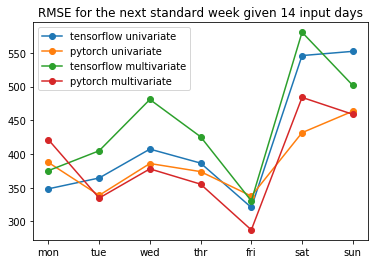

In [19]:
# plot scores
days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
plt.plot(days, rmse_tfu[1], marker='o', label='tensorflow univariate')
plt.plot(days, rmse_ptu[1], marker='o', label='pytorch univariate')
plt.plot(days, rmse_tfm[1], marker='o', label='tensorflow multivariate')
plt.plot(days, rmse_ptm[1], marker='o', label='pytorch multivariate')
plt.legend()
plt.title('RMSE for the next standard week given %s input days' % n_timesteps)
plt.show()

**save rmse**

In [20]:
l1 = ['rmse']
l2 = ['_tf', '_pt']
l3 = ['m', 'u']

In [21]:
file_names = list_combine(list_combine(l1,l2), l3)

In [22]:
for item in file_names:
    np.save(dir_data+item, eval(item)[1])